In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
data = pd.read_csv('data.csv')

data.rename(columns={'conversion':'target', 'offer': 'treatment'}, inplace=True)

data['treatment_cat'] = data['treatment']
data['treatment'] = data['treatment_cat'].map(lambda t: 0 if t == 'No Offer' else 1)

In [2]:
data['avg_gain'] = data['history']/data['recency']
data['used_both'] = data['used_discount'] & data['used_bogo']
data['used_offer'] = ((data['used_discount'] & (data['treatment_cat'] == 'Discount')) | 
                      (data['used_bogo'] & (data['treatment_cat'] == 'Buy One Get One'))).astype('int32')
data['recency_cat'] = pd.cut(data['recency'], 4, include_lowest=True, labels=[1,2,3,4]).astype('int32')

In [3]:
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,treatment_cat,avg_gain,used_both,used_offer,recency_cat
0,10,142.44,1,0,Surburban,0,Phone,1,0,Buy One Get One,14.244000,0,0,4
1,6,329.08,1,1,Rural,1,Web,0,0,No Offer,54.846667,1,0,2
2,7,180.65,0,1,Surburban,1,Web,1,0,Buy One Get One,25.807143,0,1,3


In [4]:
idx_train, idx_test = train_test_split(data.index, test_size=0.3, random_state=13)

In [5]:
cat_features = ['zip_code', 'channel', 'treatment_cat']

X_train = data.loc[idx_train].drop(['target', 'treatment'], axis=1)
y_train = data.loc[idx_train]['target']
trt_train = data.loc[idx_train]['treatment']

X_test = data.loc[idx_test].drop(['target', 'treatment'], axis=1)
y_test = data.loc[idx_test]['target']
trt_test = data.loc[idx_test]['treatment']

models_results = pd.DataFrame(index=['solo', 'class_transform', '2_models'], columns=['uplift@10%', 'uplift@20%'])

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

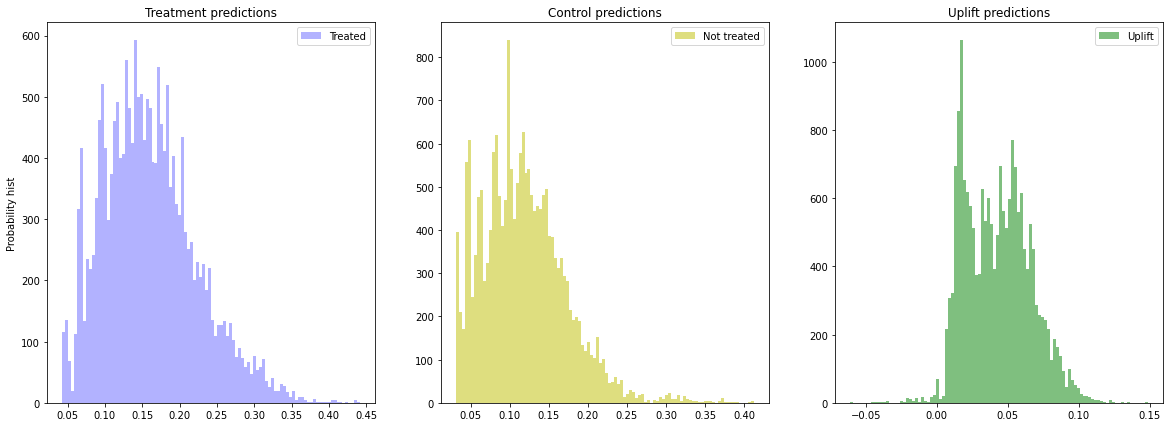

In [6]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, trt_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

for k in [10,20]:
    sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=trt_test, strategy='by_group', k=k/100)
    models_results.loc['solo', f'uplift@{k}%']= sm_score

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [7]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.550651
1,treatment,14.930964
2,zip_code,10.729939
3,used_both,9.613247
4,channel,8.947492
5,used_offer,8.911383
6,history,5.427744
7,recency,4.959335
8,recency_cat,4.825838
9,used_discount,4.558765


<AxesSubplot:xlabel='uplift_cat'>

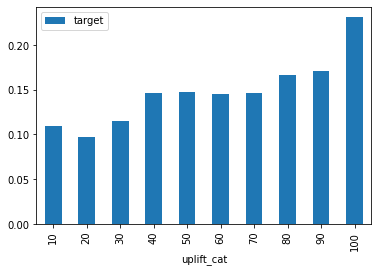

In [8]:
pred = pd.Series({i:v for i, v in zip(idx_test,uplift_sm)})
pred_q = pd.qcut(pred, 10, labels=range(10,101,10)).rename('uplift_cat')
q_conv = pd.DataFrame([pred_q,y_test]).T
q_conv.groupby('uplift_cat').mean().plot.bar()

#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [9]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, trt_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

for k in [10,20]:
    ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=trt_test, strategy='by_group', k=k/100)
    models_results.loc['class_transform', f'uplift@{k}%']= ct_score

#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

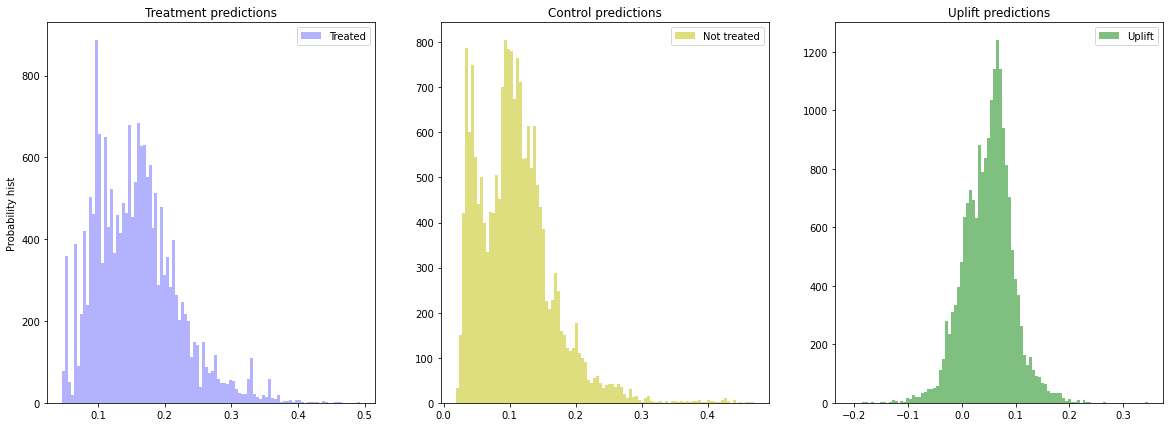

In [10]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, trt_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

for k in [10,20]:
    tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=trt_test, strategy='by_group', k=k/100)
    models_results.loc['2_models', f'uplift@{k}%']= tm_score

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [11]:
models_results

,uplift@10%,uplift@20%
solo,0.107455,0.086961
class_transform,0.269754,0.230701
2_models,0.128701,0.097226


#### Вариант с деревом решений

In [12]:
for i in cat_features:
    X_train_tree = pd.concat([X_train.drop(i, 1), 
                          pd.get_dummies(X_train[i], prefix=i)], 1)
features = [col for col in X_train_tree]

C:\Users\COSMOT~1\AppData\Local\Temp/ipykernel_4628/3357148387.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_tree = pd.concat([X_train.drop(i, 1),
C:\Users\COSMOT~1\AppData\Local\Temp/ipykernel_4628/3357148387.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  X_train_tree = pd.concat([X_train.drop(i, 1),


Wall time: 20.7 s


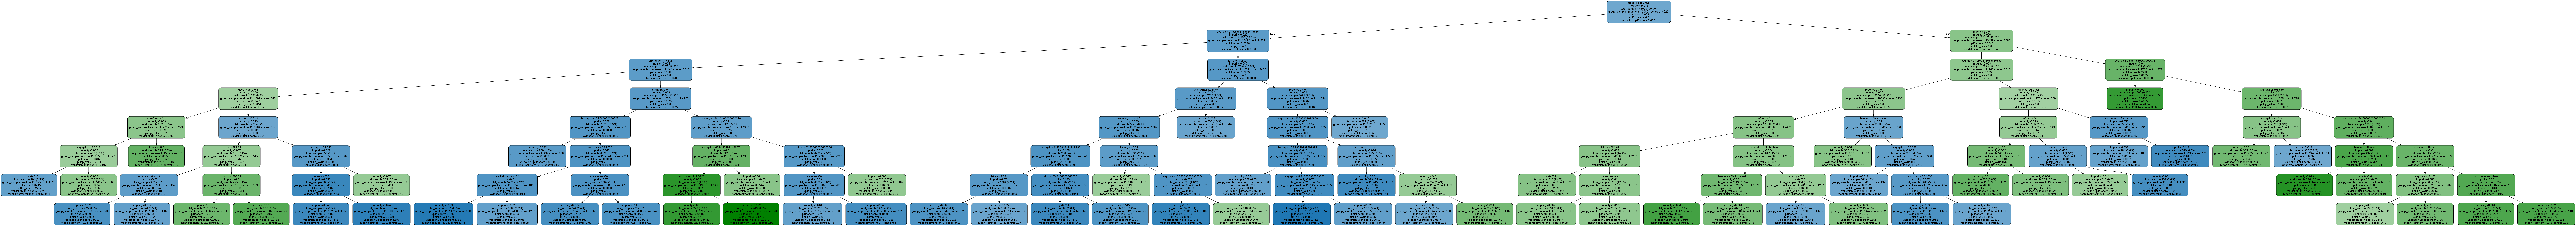

In [13]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=trt_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())